# Simulación Ficticia de Pandemia COVID-19

En diciembre de 2019 fueron reportados una serie de casos de pacientes hospitalizados con una enfermedad nueva caracterizada por neumonía e insuficiencia respiratoria, a causa de un nuevo coronavirus (SARS-CoV-2), en la provincia de Hubei, China. El 11 de febrero de 2020, la Organización Mundial de la Salud nombró este agente etiológico como COVID-19 (Coronavirus Disease, 2019).

Posteriormente, y a pesar de las extensas medidas de contención, la enfermedad ha continuando avanzando hasta afectar al resto de los países de Asia, Medio Oriente y Europa. El 11 de marzo, la COVID-19 fue declarada como pandemia en una rueda de prensa mundial. Sin embargo, con el paso del tiempo, la pandemia se ha ido regulando y ha dejado de estar presente en el planeta en forma impactante, por lo que cada vez más hay menos contagios.

A partir de esto, es importante aclarar que la siguiente simulación está adaptada a un caso en donde existen 10000 personas y estas interactúan entre sí. Además, en este ambiente, están presentes las probabilidades, por lo que esta simulación es más controlada y depende de esto.
<center>
<img src="https://www.paho.org/sites/default/files/2023-08/covid-19-variants.jpg" width=75% />
</center>

## Reglas

El universo (o entorno) de la Pandemia COVID-19 es finito, cuadrícula ortogonal bidimensional de celdas cuadradas (que representan a las personas), cada una de ellas se encuentra con uno de cuatro posibles estados: no contagiado, contagiado, muerto o inmune. Sin embargo, el entorno se inicializa con únicamente personas contagiadas y no contagiadas. Cada persona interactúa con ocho vecinos, que son las celdas adyacentes horizontales, verticales y diagonales. En cada paso de tiempo, las siguientes transiciones ocurren:

1. Cualquier persona no contagiada con al menos cinco vecinos contagiados, es contagiada.
2. Cualquier persona contagiada que tenga contacto con al menos tres vecinos inmunes, se vuelve no contagiada.
3. Cualquier persona contagiada que este en ese estado por cada cinco meses, tiene un 70% de probabilidad de morir o 30% de ser inmune.
4. Cualquier persona no contagiada que sobreviva por cada tres meses, tiene un 95% de probabilidad de ser inmune o 5% de ser no contagiada.
5. Cualquier persona inmune que este en ese estado por cada año (12 meses), tiene un 15% de probabilidad de contagiarse de nuevo u 85% de no contagiarse.
La probabilidad por cada año se reduce gradualmente para la probabilidad de contagiarse y aumenta gradualmente para la probabilidad de no contagiarse.

El patrón inicial constituye la semilla del sistema. En el primer mes, lo que ocurre es creado al aplicar las reglas anteriores de manera simultanea a cualquier celda en la semilla: no contagiada o contagiada; inmunidades, curaciones, contagios y muertes ocurren simultáneamente, y el momento discreto en el cual esto pasa se le llama turno. Cada mes es una función pura de la anterior. Las reglas se aplican de forma repetida para avanzar en el tiempo a través del paso de meses. Por ello, es evidente que, las reglas están adaptadas a lo que pasaría en la actualidad al estar en una pandemia con estos acontecimientos. De esto, las probabilidades en las reglas están puestas ahí en base a un análisis hecho en el contexto actual de una variante agresiva de este virus.

## Instalación de MESA

In [ ]:
!python3 -m pip install mesa

## Imports

Antes de empezar a crear el modelo de la Pandemia COVID-19 con multiagentes es necesario tener instalado los siguientes paquetes:
- `python`: asegúrense de usar la versión 3+.
- `mesa`: el framework de Python para el modelado de agentes.
- `numpy`: es una biblioteca de Python para el manejo de matrices, arreglos, manipulación matemática, lógica y mucho más.
- `matplotlib`: es una biblioteca para crear visualizaciones estáticas, animadas e interactivas en Python.

Para poder modelar la pandemia usando el framework de `mesa` es necesario importar dos clases: una para el modelo general, y otro para los agentes.

In [ ]:
# 'Model' sirve para definir los atributos a nivel del modelo, maneja los agentes
# 'Agent' es la unidad atómica y puede ser contenido en múltiples instancias en los modelos
from mesa import Agent, Model

# 'SingleGrid' sirve para forzar a un solo objeto por celda (nuestro objetivo en este "juego")
from mesa.space import SingleGrid

# 'SimultaneousActivation' habilita la opción de activar todos los agentes de manera simultanea.
from mesa.time import SimultaneousActivation

# 'DataCollector' permite obtener el grid completo a cada paso (o generación), útil para visualizar
from mesa.datacollection import DataCollector

# 'matplotlib' lo usamos para graficar/visualizar como evoluciona el autómata celular.
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mlp
import matplotlib.animation as animation
import matplotlib.lines as mlines
import matplotlib.patches as mpatches
plt.rcParams["animation.html"] = "jshtml"
mlp.rcParams['animation.embed_limit'] = 2**128

# Definimos los siguientes paquetes para manejar valores númericos: 'numpy' & 'pandas'
import numpy as np
import pandas as pd

# Definimos otros paquetes que vamos a usar para medir el tiempo de ejecución de nuestro algoritmo.
import time
import datetime
import random

## Crear el modelo

Antes que nada, el presente modelo se encuentra basado en el tutorial de Mesa. Se modificó para que funcionara con el presente problema pero en esencia es lo mismo.

In [ ]:
class PandemicAgent(Agent):
    # Constructor de la clase PandemicAgent
    # Inicializa el agente con un estado inicial aleatorio (contagiado o no contagiado).
    # También establece tiempos de no contagio, contagio e inmunidad, y probabilidades iniciales.
    def __init__(self, unique_id, model):
        super().__init__(unique_id, model)
        self.state = np.random.choice(["no_contagiada", "contagiada"], p=[0.75, 0.25])
        self.next_state = None
        self.non_contagion_time = 0
        self.contagion_time = 0
        self.immunity_time = 0
        self.contagiada_probability = 0.1  # Probabilidad inicial de ser "contagiada"
        self.no_contagiada_probability = 0.9  # Probabilidad inicial de ser "no_contagiada"

    # Método que define el comportamiento de los agentes en cada paso de la simulación.
    # Verifica la cantidad de vecinos contagiados e inmunes, y actualiza el estado del agente según reglas específicas.
    # Puede cambiar gradualmente las probabilidades de contagiarse o no contagiarse si está inmunizado.
    def step(self):
        neighbors = self.model.grid.get_neighbors(
            self.pos,
            moore=True,
            include_center=False)

        contagious_neighbors = sum(1 for neighbor in neighbors if neighbor.state == "contagiada")
        immune_neighbors = sum(1 for neighbor in neighbors if neighbor.state == "inmune")

        self.next_state = self.state

        # Se definen las reglas de la simulación
        # 1. Cualquier persona no contagiada con al menos cinco vecinos contagiados, es contagiada.
        if self.state == "no_contagiada" and contagious_neighbors >= 5:
            self.next_state = "contagiada"
        # 2. Cualquier persona contagiada que tenga contacto con al menos tres vecinos inmunes, se vuelve no contagiada.
        elif self.state == "contagiada" and immune_neighbors >= 3:
            self.next_state = "no_contagiada"

        # 3. Cualquier persona contagiada que este en ese estado por cada cinco meses, tiene un 70% de probabilidad de morir o 30% de ser inmune.
        if self.state == "contagiada":
            # Check if the person has been contagious for three months
            if (self.model.schedule.time - self.contagion_time) % 5 == 0 and (self.model.schedule.time - self.contagion_time) != 0:
                self.next_state = np.random.choice(["muerta", "inmune"], p=[0.7, 0.3])
        # 4. Cualquier persona no contagiada que sobreviva por cada tres meses, tiene un 95% de probabilidad de ser inmune o 5% de ser no contagiada.
        elif self.state == "no_contagiada":
            if (self.model.schedule.time - self.non_contagion_time) % 3 == 0 and (self.model.schedule.time - self.non_contagion_time) != 0:
                self.next_state = np.random.choice(["inmune", "no_contagiada"], p=[0.95, 0.05])
        # 5. Cualquier persona inmune que este en ese estado por cada año (12 meses), tiene un 15% de probabilidad de contagiarse de nuevo u 85% de no contagiarse.
        # La probabilidad por cada año se reduce gradualmente para la probabilidad de contagiarse y aumenta gradualmente para la probabilidad de no contagiarse.
        elif self.state == "inmune":
            if (self.model.schedule.time - self.immunity_time) % 12 == 0 and (self.model.schedule.time - self.immunity_time) != 0:
                # Calcula la nueva probabilidad gradualmente
                t = self.model.schedule.time - self.immunity_time
                self.contagiada_probability = max(0, 0.15 - 0.0015 * t)  # Reducción gradual
                self.no_contagiada_probability = min(1, 0.85 + 0.0015 * t)  # Aumento gradual

                self.next_state = np.random.choice(["contagiada", "no_contagiada"], p=[self.contagiada_probability, self.no_contagiada_probability])

    # Método que define el nuevo estado calculado del método step.
    def advance(self):
        self.state = self.next_state

# Se define el modelo de la simulación de la pandemia COVID-23
class PandemicModel(Model):
    # Constructor de la clase PandemicModel
    # Inicializa el modelo de la simulación de pandemia con el ancho y alto de la cuadrícula.
    def __init__(self, width, height):
        self.width = width
        self.height = height

        self.reset()

    # Reinicia la simulación. Crea la cuadrícula y coloca a los agentes en ella según el estado inicial.
    # También inicializa el colector de datos para la visualización.
    def reset(self):
        self.num_agents = self.width * self.height
        self.grid = SingleGrid(self.width, self.height, True)
        self.schedule = SimultaneousActivation(self)

        for (content, pos) in self.grid.coord_iter():
            a = PandemicAgent(pos, self)
            self.grid.place_agent(a, pos)
            self.schedule.add(a)

            if a.state == "no_contagiada":
                a.non_contagion_time = self.schedule.time
            if a.state == "contagiada":
                a.contagion_time = self.schedule.time
            if a.state == "inmune":
                a.immunity_time = self.schedule.time

        # Define el colector de datos para obtener el estado de cada celda.
        self.datacollector = DataCollector(
            model_reporters={"Grid": self.get_grid,
                             "No_Contagiada": lambda model: self.count_agents(model, "no_contagiada"),
                             "Contagiada": lambda model: self.count_agents(model, "contagiada"),
                             "Muerta": lambda model: self.count_agents(model, "muerta"),
                             "Inmune": lambda model: self.count_agents(model, "inmune")}
        )

    # Realiza un paso en la simulación. Recopila datos sobre el estado de las celdas y hace que los agentes ejecuten su método step.
    def step(self):
        """
        En cada paso, el colector toma la información del estado de las celdas y la almacena para su visualización.
        """
        self.datacollector.collect(self)
        self.schedule.step()

    # Función auxiliar que guarda el estado de cada celda en un grid para su visualización.
    def get_grid(self):
        """
        Esta función auxiliar permite guardar el estado de cada celda en un grid.
        """

        grid = np.zeros((self.grid.width, self.grid.height), dtype=int)
        for cell in self.grid.coord_iter():
            cell_content, pos = cell
            x, y = pos
            if cell_content.state == "no_contagiada":
                grid[x][y] = 0
            elif cell_content.state == "contagiada":
                grid[x][y] = 1
            elif cell_content.state == "muerta":
                grid[x][y] = 2
            elif cell_content.state == "inmune":
                grid[x][y] = 3
        return grid

    # Función auxiliar que cuenta la cantidad de agentes en un estado específico en la cuadrícula.
    def count_agents(self, model, agent_state):
        """
        Esta función auxiliar cuenta la cantidad de agentes en un estado específico.
        """
        agent_count = 0
        for cell in model.grid.coord_iter():
            agent, _ = cell
            if agent.state == agent_state:
                agent_count += 1
        return agent_count

# Ejecución del modelo
A continuación corremos el modelo

In [ ]:
# Se define el tamaño del Grid -> 100 x 100
GRID_SIZE = 100

# Se define el número de meses a correr
NUM_MONTHS = 100

# Se registra el tiempo de inicio y corremos el modelo
start_time = time.time()

# Se define el modelo de tipo PandemicModel con un tamaño cuadrangular del GRID_SIZE
model = PandemicModel(GRID_SIZE, GRID_SIZE)
for i in range(NUM_MONTHS):
    model.step()
final_time = time.time()

# Se imprime el tiempo que le tomó correr al modelo.
print('Tiempo de ejecución:', str(datetime.timedelta(seconds=(final_time - start_time))))

Tiempo de ejecución: 0:00:15.784051


Obtenemos la información que almacenó el colector, este nos entregará un DataFrame de pandas que contiene toda la información.

In [ ]:
all_grids = model.datacollector.get_model_vars_dataframe()

Graficamos la información usando `matplotlib`

In [ ]:
all_grids

,Grid,No_Contagiada,Contagiada,Muerta,Inmune
0,"[[1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1,...",7408,2592,0,0
1,"[[1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1,...",7172,2828,0,0
2,"[[1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1,...",6993,3007,0,0
3,"[[1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1,...",6864,3136,0,0
4,"[[1, 3, 3, 1, 1, 1, 1, 1, 1, 3, 1, 3, 1, 3, 1,...",355,3136,0,6509
...,...,...,...,...,...
95,"[[2, 2, 3, 2, 2, 2, 2, 2, 3, 2, 3, 2, 2, 3, 2,...",2,0,3339,6659
96,"[[2, 2, 3, 2, 2, 2, 2, 2, 3, 2, 3, 2, 2, 3, 2,...",2,0,3339,6659
97,"[[2, 2, 0, 2, 2, 2, 2, 2, 0, 2, 0, 2, 2, 0, 2,...",6618,41,3339,2
98,"[[2, 2, 0, 2, 2, 2, 2, 2, 0, 2, 0, 2, 2, 0, 2,...",6618,41,3339,2


## Visualización del modelo
Después, realizamos el código para visualizar el modelo

In [ ]:
%%capture

# Visualizamos la evolución del estado de la pandemia
fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(7,7))

axs.set_xticks([])
axs.set_yticks([])

colors = [
    np.array([0 / 255, 255 / 255, 0 / 255, 1]),  # No Contagiada (VERDE)
    np.array([255 / 255, 0 / 255, 0 / 255, 1]),  # Contagiada (ROJO)
    np.array([0 / 255, 0 / 255, 0 / 255, 1]),  # Muerta (NEGRO)
    np.array([0 / 255, 0 / 255, 255 / 255, 1])  # Inmune (AZUL)
]

colormap = mlp.colors.ListedColormap(colors)

patch_grid = axs.imshow(all_grids['Grid'].iloc[0], cmap=colormap, vmin=0, vmax=3)

cells_no_contagiadas = []
cells_contagiadas = []
cells_muertas = []
cells_inmunes = []

def animate(i):
    patch_grid.set_data(all_grids['Grid'].iloc[i])
    axs.set_title(f'Mes {i}')  # Muestra el número de mes en el título

    cells_no_contagiadas.append(all_grids['No_Contagiada'].iloc[i])
    cells_contagiadas.append(all_grids['Contagiada'].iloc[i])
    cells_muertas.append(all_grids['Muerta'].iloc[i])
    cells_inmunes.append(all_grids['Inmune'].iloc[i])

anim = animation.FuncAnimation(fig, animate, frames=NUM_MONTHS)

Mandamos llamar a la animación del modelo

In [ ]:
anim

## Visualización de las estadísticas
En base a la visualización del modelo, la información obtenida y analizada conforme se iba corriendo el programa, fue utilizada para visualizar una gráfica.


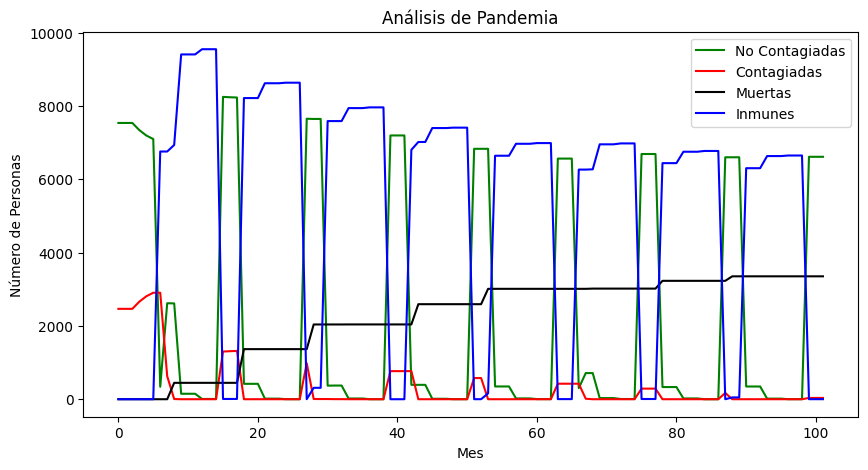

In [ ]:
fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(10, 5))

axs.set_title("Análisis de Pandemia")
axs.set_xlabel("Mes")
axs.set_ylabel("Número de Personas")

plt.plot(cells_no_contagiadas, label='No Contagiadas', color='green')
plt.plot(cells_contagiadas, label='Contagiadas', color='red')
plt.plot(cells_muertas, label='Muertas', color='black')
plt.plot(cells_inmunes, label='Inmunes', color='blue')
plt.legend()

plt.show()

# Simulación con repeticiones
Dado el modelo, para este análisis únicamente se ocupa adaptar el código para que se realicen distintas repeticiones en la simulación del modelo.


In [ ]:
NUM_REPS = 50
GRID_SIZE = 100
NUM_MONTHS = 100

model = PandemicModel(GRID_SIZE, GRID_SIZE)

batch_data = dict(tiempo=[], personas_contagiadas=[], personas_no_contagiadas=[])
for _ in range(NUM_REPS):
    start_time = time.time()

    model.reset()
    for i in range(NUM_MONTHS):
        model.step()
    final_time = time.time()

    all_grids = model.datacollector.get_model_vars_dataframe()

    batch_data['tiempo'].append(final_time - start_time)
    batch_data['personas_no_contagiadas'].append(all_grids['No_Contagiada'].to_numpy())
    batch_data['personas_contagiadas'].append(all_grids['Contagiada'].to_numpy())

## Visualización de las estadísticas adaptadas
Una vez corrido este código, podemos visualizar la información relevante (las personas contagiadas y no contagiadas). En este primer caso, se codifican las personas no contagiadas.


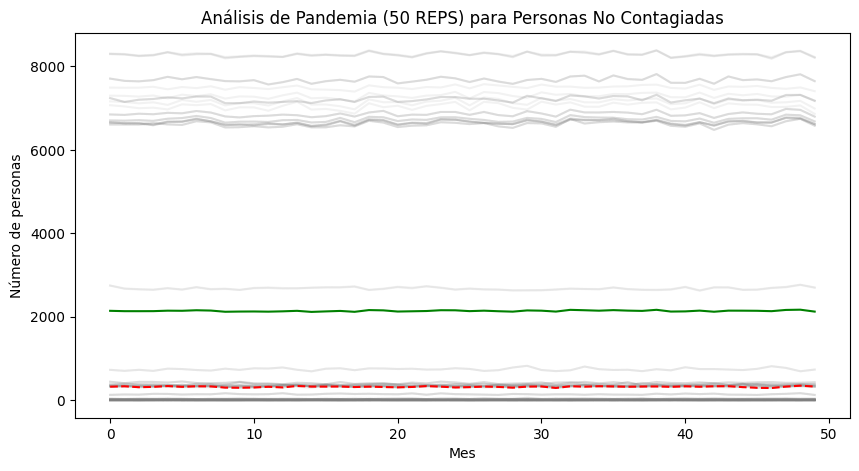

In [ ]:
fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(10,5))

axs.set_title("Análisis de Pandemia (50 REPS) para Personas No Contagiadas")
axs.set_xlabel("Mes")
axs.set_ylabel("Número de personas")

#axs.set_prop_cycle('color', list(plt.cm.(np.linspace(0, 1, NUM_REPS))))
plt.plot(batch_data['personas_no_contagiadas'], color='Grey', alpha=0.1)

plt.plot(np.average(np.array(batch_data['personas_no_contagiadas']), axis=1), color='Green')
plt.plot(np.median(np.array(batch_data['personas_no_contagiadas']), axis=1), color='Red', linestyle='dashed')

plt.show()

En este segundo caso, se codifican las personas contagiadas.

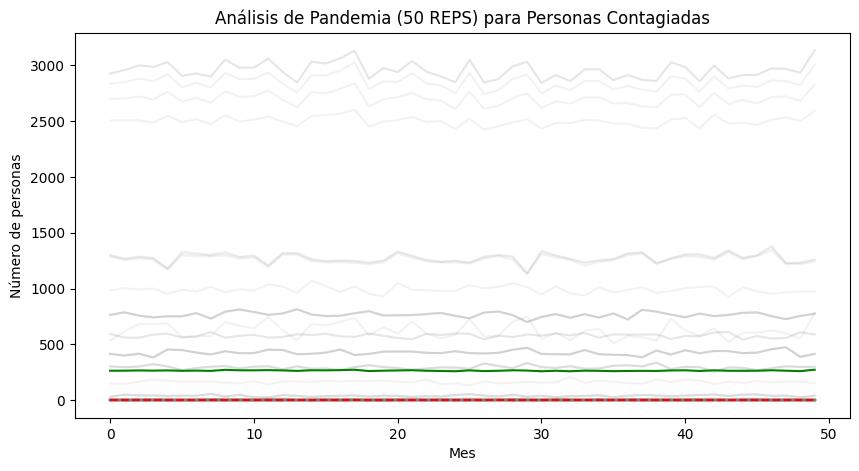

In [ ]:
fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(10,5))

axs.set_title("Análisis de Pandemia (50 REPS) para Personas Contagiadas")
axs.set_xlabel("Mes")
axs.set_ylabel("Número de personas")

#axs.set_prop_cycle('color', list(plt.cm.(np.linspace(0, 1, NUM_REPS))))
plt.plot(batch_data['personas_contagiadas'], color='Grey', alpha=0.1)

plt.plot(np.average(np.array(batch_data['personas_contagiadas']), axis=1), color='Green')
plt.plot(np.median(np.array(batch_data['personas_contagiadas']), axis=1), color='Red', linestyle='dashed')

plt.show()